In [1]:
import numpy as np
import tensorflow.keras as keras
from scipy import stats
from scipy.spatial.distance import cosine
import seaborn as sns
import pickle
from tensorflow.keras import backend as K 

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# MNIST Data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(f"train: {int(len(x_train) * 0.9)}, validation: {int(len(x_train) * 0.1)}, test: {len(x_test)}")

train: 54000, validation: 6000, test: 10000


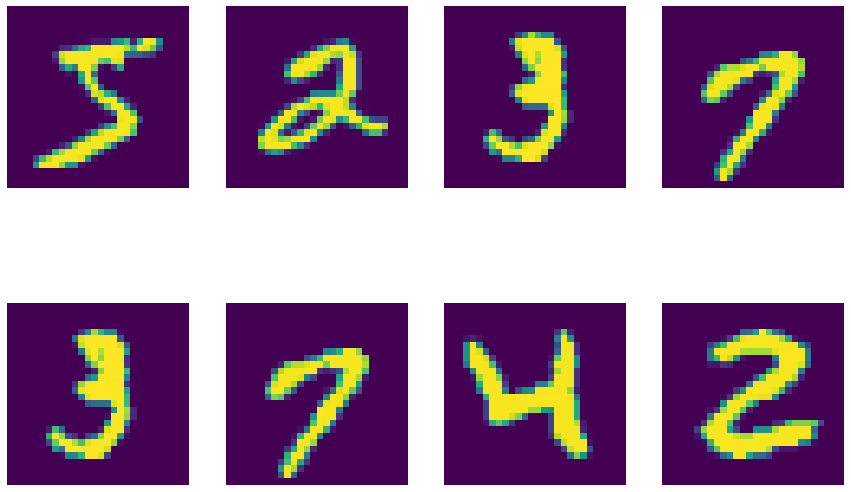

In [3]:
fig, ax = plt.subplots(2,4, figsize=(15,10))
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(x_train[i*10 + j * 5, :, :, 0])
        ax[i,j].set_axis_off()
plt.show()

# Baseline

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=x_train.shape[1:]),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
batch_size = 128
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", keras.metrics.AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                3

In [5]:
%%time
epochs = 15
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

CPU times: user 28.1 s, sys: 3.8 s, total: 31.9 s
Wall time: 50.7 s


In [6]:
with open('cl_seacher_files/II_4.pkl', 'wb') as f: #path to save
    pickle.dump(history.history, f)

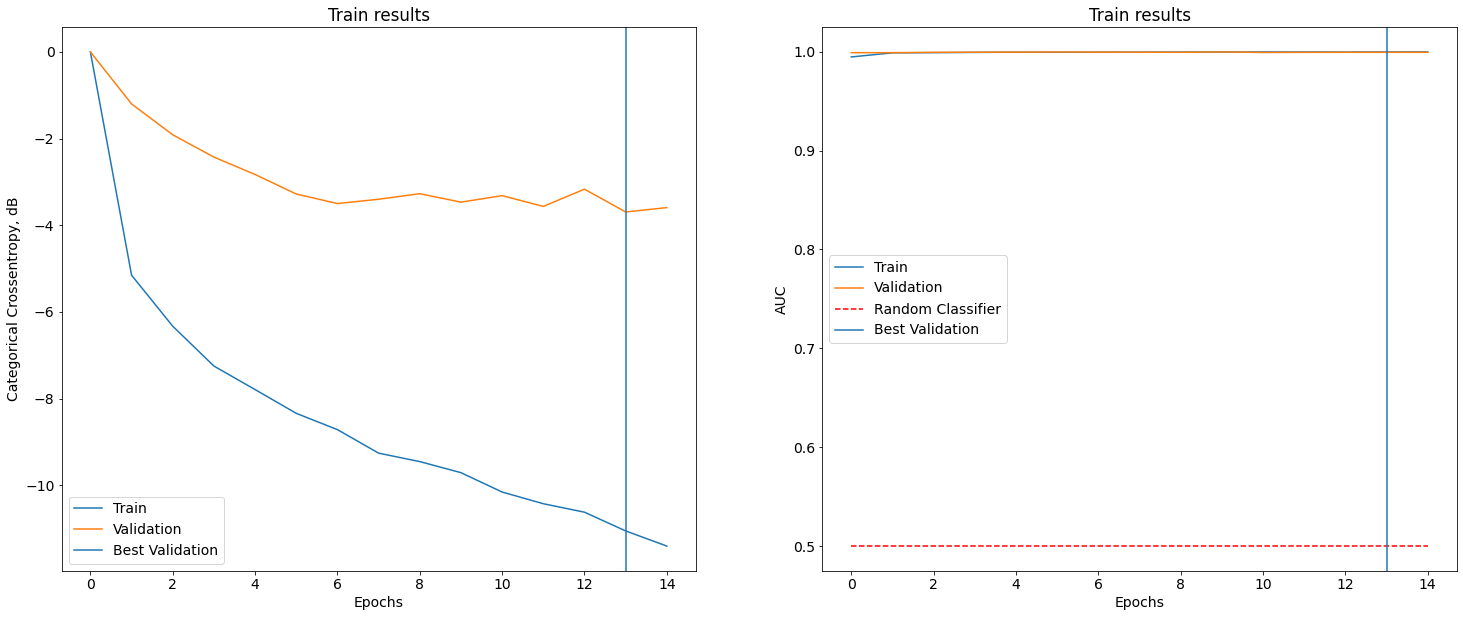

In [8]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 2, figsize=(25,10))
ax[0].plot(10 * np.log10(np.array(history.history["loss"]) / history.history["loss"][0]), label="Train")
ax[0].plot(10 * np.log10(np.array(history.history["val_loss"]) / history.history["val_loss"][0]), label="Validation")
ax[0].axvline(np.argmin(history.history["val_loss"]), label="Best Validation")
ax[0].set_title("Train results")
ax[0].set_ylabel("Categorical Crossentropy, dB")
ax[0].set_xlabel("Epochs")
ax[0].legend(loc="best")

ax[1].plot(history.history["auc"], label="Train")
ax[1].plot(history.history["val_auc"], label="Validation")
ax[1].plot([0.5 for x in range(len(history.history["loss"]))], "r--", label="Random Classifier")
ax[1].axvline(np.argmin(history.history["val_loss"]), label="Best Validation")
ax[1].set_title("Train results")
ax[1].set_ylabel("AUC")
ax[1].set_xlabel("Epochs")
ax[1].legend(loc="best")

plt.subplots_adjust(hspace=.3)
plt.show()

# Estimation
1. Normality test
2. Twin filters

In [9]:
pvalue = 0.005
treshold = 0.2

In [11]:
def check_normal_layer(weights: np.array, pvalue:float) -> list:
    if sum(weights.shape[:-1]) < 10:
        return []
    
    init_num_filters = weights.shape[-1]
    drop = []
    for w in range(init_num_filters):
        _, p = stats.normaltest(weights[:,:,:,w].flatten())
        if p > pvalue:
            drop.append(w)
        else:
            continue
    
    return drop

In [12]:
def cosine_test_layer(weights: np.array, treshold=0.1) -> tuple:
    confusion = np.eye(weights.shape[-1])
    for i in range(weights.shape[-1]):
        for j in range(weights.shape[-1]):
            if i != j:
                confusion[i, j] = cosine(weights[:,:,:,i].flatten(), weights[:,:,:,j].flatten())
            else:
                continue
                
    new_confusion = np.delete(confusion, np.where(confusion < treshold)[0], axis=0)
    return np.where(confusion < treshold)[0], confusion, new_confusion

In [13]:
def model_check_cl_layers(layers:list, pvalue=0.005, treshold=0.1, verbose=True) -> dict:
    old_config = dict()
    new_config = dict()
    
    if verbose:
        print("{:10s} | {:18s} | {:18s} | {:18s} | {:23s} |".format("Layer", "First Test", "Second Test", "Discarded", "Discarded [%]"))
    
    for idx, layer in enumerate(layers, start=1):
        if isinstance(layer, keras.layers.Conv2D):
            old_config[f"CL_{idx}"] = layer.get_weights()[0].shape[-1]
            first_drop = check_normal_layer(layer.get_weights()[0], pvalue=pvalue)
            second_drop, _, _ = cosine_test_layer(layer.get_weights()[0], treshold=treshold)
            all_drop = set(first_drop).union(set(second_drop))
            new_config[f"CL_{idx}"] = old_config[f"CL_{idx}"] - len(all_drop)
            if verbose:
                print("{:10s} | {:18s} | {:18s} | {:18s} | {:23s} |".format(
                    f"CL_{idx}",
                    str(len(first_drop)), 
                    str(len(set(second_drop))), 
                    str(len(all_drop)), 
                    str(round(len(all_drop) / old_config[f"CL_{idx}"] * 100., 3)) + " %"
                ))
    return new_config

# Step of the search algorithm

In this notebook, each step of the algorithm is run manually. If you want to write `for`-loop use:

<code> 
from keras import backend as K
....
for i in n:
    K.clean_session()
    <постороение новой модели>
</code> 

In [14]:
a = model_check_cl_layers(model.layers, pvalue=pvalue, treshold=treshold)

Layer      | First Test         | Second Test        | Discarded          | Discarded [%]           |
CL_1       | 0                  | 45                 | 45                 | 70.312 %                |
CL_3       | 48                 | 0                  | 48                 | 37.5 %                  |


In [15]:
print("New hyperparameters:")
for k,v in a.items():
    print(k, v)

New hyperparameters:
CL_1 19
CL_3 80


## Visualization
1. Pairwise cosine distance for one layer

In [16]:
a, b, c = cosine_test_layer(model.layers[0].get_weights()[0])

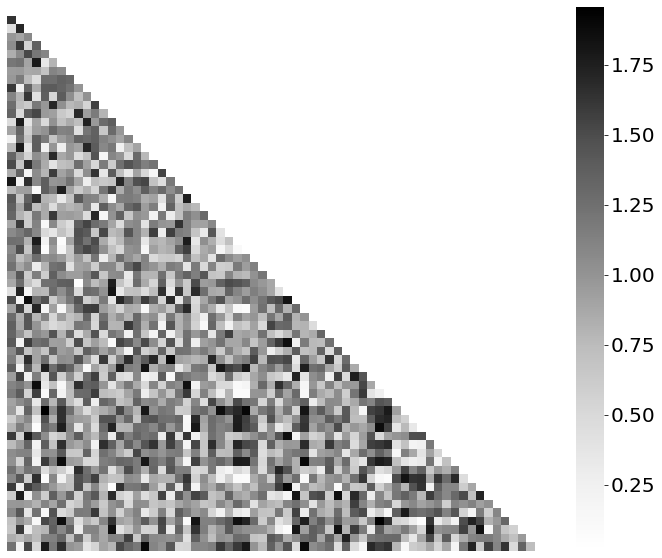

In [17]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, figsize=(12,10))
mask = np.triu(b)
sns.heatmap(b, ax=ax, mask=mask, cmap='Greys')
ax.axis("off")

plt.show()

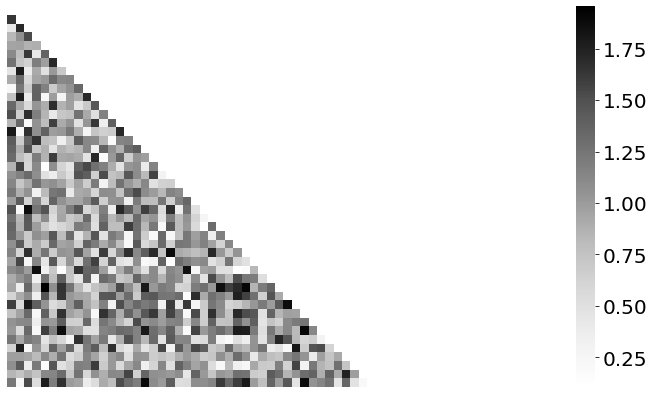

In [18]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, figsize=(12,7))
mask = np.triu(c)
sns.heatmap(c, ax=ax, mask=mask, cmap='Greys')
ax.axis("off")

plt.show()

2. Building a search trajectory in the hyperparameters space

In [20]:
import os

In [21]:
hisories = {}
for i in os.listdir("cl_seacher_files/"): # path to saved steps
    if "II" in i:
        with open("cl_seacher_files/" + i, 'rb') as f:
            hisories[i.split(".")[0]] = pickle.load(f)

Found hyperparameters

In [22]:
a = [64, 43, 37, 31, 29, 25]
b = [128, 76, 36, 14, 5, 3]

In [23]:
c = [64, 21, 13]
d = [128, 81, 28]

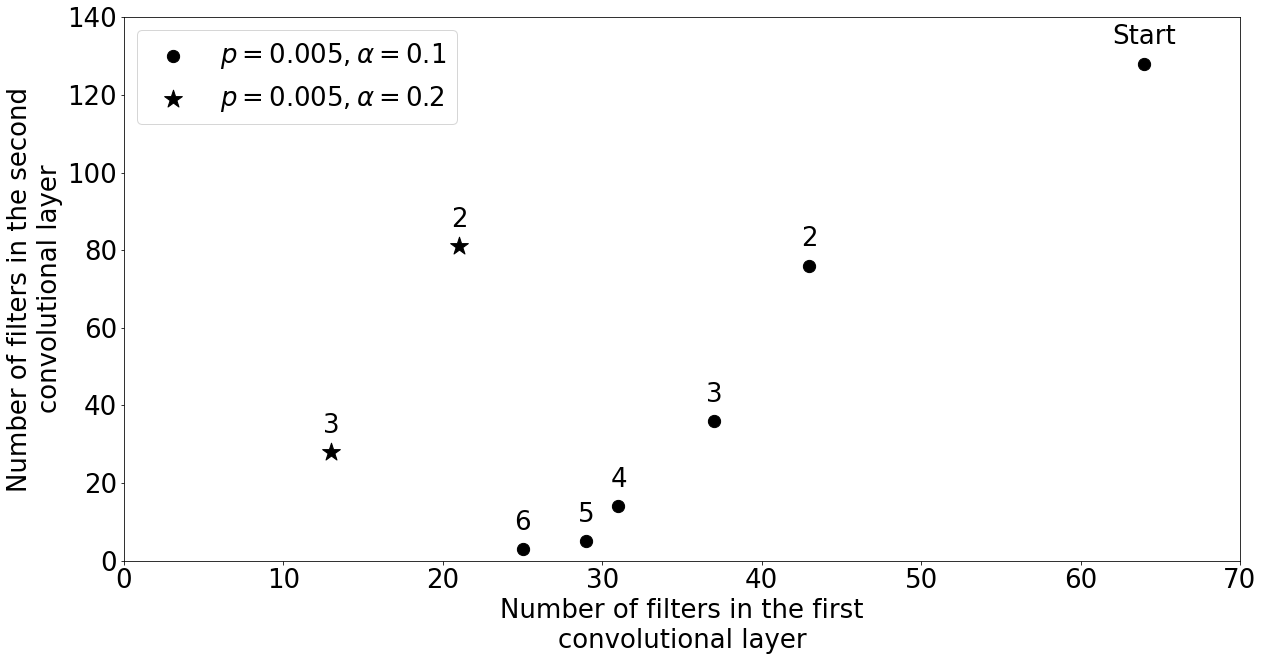

In [24]:
plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(1, figsize=(20,10))
ax.scatter(a,b, color="k", s=150, label=r"$p=0.005, \alpha=0.1$")
for i, txt in enumerate(a):
    if i != 0:
        ax.annotate(i + 1, (a[i], b[i]), xytext=(a[i]-0.5, b[i] + 5))
    else:
        ax.annotate("Start", (a[i], b[i]), xytext=(a[i]-2, b[i] + 5))
ax.scatter(c[1:],d[1:], color="k", marker='*', s=350, label=r"$p=0.005, \alpha=0.2$")
for i, txt in enumerate(c):
    if i != 0:
        ax.annotate(i + 1, (c[i], d[i]), xytext=(c[i]-0.5, d[i] + 5))
ax.legend(loc="upper left")
ax.set_ylim([0, 140])
ax.set_xlim([0, 70])
ax.set_xlabel("Number of filters in the first\nconvolutional layer")
ax.set_ylabel("Number of filters in the second\nconvolutional layer")

plt.show()